## What was discovered?
* is_tourney (remark when game was in regular or tourney phase) variable doesnt matter according to feature importance and also we will predict only tourney phase games.
* to addres the problem of data leakage I removed scores from games (before game we dont know which teams shoot how many points) and also for every team i retrieve seed values. But if it is regular season i only have information about previous ones. So for regular season I retrieve seed from previous season and for tourney phase i retrieve information from current season.
* team coaches can have also some important informations (some coaches are better than other). But during the season team coache can be changed. So apart classic merge I have to check also if in particular row daynum is smaller than last day and bigger than first day of coach term.
* DayNum feature can carry some information. But in this contest we do not have information about matches (we have to predict every possible matchup). Feature importance indicate it is important feature.
* Ranking provide a lot of information. In data we have a massive ranking, which contains a team's ranking from a lot of rankings. There is above 100 rankings. So i will caluclate median for certain game for particular team. Also we dont have rankings for every daynum, so i merged data on teams ID, Season and DayNum, then groupby this columns and i take the last one element. Therefor I will have always the last one. To prevent data leakage I removed all rows contain ranking after the daynum of game. So I excluded information which I won't have during predicitons. As we can see the mutual information and random forest indicate it is a important feature.
* Next features are very important, because number of wins and average number of scored points can be really helpful. As humans try to bet on games we often checks on which position team is, how many wins have or how many scored points. So it can convey a lot of information.

## Which features was added?
* seed value for every team
* difference between seed of one team and another
* team coach information
* duration of teams presence in Division I
* ranking's median
* average amount of scored points (in particular season - if it is a 15 game for a team, mean will be calculate for previous 14)
* number of wins in particular season (if it is a 15 game, sum will be calucalted from 14 previous games)
* average of the detailed metrics like assists, blocks etc.

## Load libraries

In [1]:
import fireducks.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import brier_score_loss, f1_score, brier_score_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from custom_utils import transform_data, enrich_data, feature_importance
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from collections import defaultdict

## Load and prepare data

In [2]:
wregularseason = pd.read_csv("data/WRegularSeasonCompactResults.csv")
wtourneyseason = pd.read_csv("data/WNCAATourneyCompactResults.csv")

mregularseason = pd.read_csv("data/MRegularSeasonCompactResults.csv")
mtourneyseason = pd.read_csv("data/MNCAATourneyCompactResults.csv")

mseason = pd.read_csv("data/MSeasons.csv")
wseason = pd.read_csv("data/WSeasons.csv")

wdata = pd.concat([wregularseason, wtourneyseason], axis=0)
wdata = wdata.loc[wdata.Season > 2015].reset_index(drop=True)

mdata = pd.concat([mregularseason, mtourneyseason], axis=0).reset_index(drop=True)
mdata = mdata.loc[mdata.Season > 2015].reset_index(drop=True)

wprep = transform_data(wdata)
mprep = transform_data(mdata)

In [3]:
mprep_enh = enrich_data(mprep, "M")
wprep_enh = enrich_data(wprep, "W")
display(wprep_enh.head())
mprep_enh.head()

/home/kacper/Projects/Forecasting-NCAA-BB/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kacper/Projects/Forecasting-NCAA-BB/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,Season,DayNum,WTeamID,LTeamID,Result,LScore,WScore,Lwin,Wwin,is_tournament,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2016,11,3343,3110,1,0.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016,11,3376,3326,1,0.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016,11,3408,3114,1,0.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016,11,3110,3343,0,0.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,11,3326,3376,0,0.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Season,DayNum,WTeamID,LTeamID,Result,LScore,WScore,Lwin,Wwin,is_tournament,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2016,16,1103,1116,1,0.0,0.0,0,0,0,...,15.0,14.0,26.0,17.0,26.0,21.0,14.0,10.0,6.0,24.0
1,2016,16,1113,1244,1,66.5,73.0,2,1,0,...,19.0,16.5,22.0,13.0,26.5,8.0,16.5,6.0,2.0,21.5
2,2016,16,1116,1103,0,0.0,0.0,0,0,0,...,19.0,10.0,19.0,12.0,29.0,13.0,15.0,5.0,3.0,18.0
3,2016,16,1117,1366,0,0.0,0.0,0,0,0,...,13.0,16.0,27.0,7.0,24.0,8.0,17.0,9.0,3.0,23.0
4,2016,16,1119,1192,1,54.0,75.0,1,1,0,...,26.0,13.0,18.0,9.0,28.0,12.0,13.0,10.0,0.0,25.0


In [4]:
mprep_temp = mprep_enh[["Season", "DayNum", "WTeamID", "LTeamID"]]


## Test model on different features

### Divide dataset on X and y, define time series split function

In [5]:
X_featm = mprep_enh.drop(["Result", "DayNum"], axis=1)
ym = mprep_enh.Result

X_featw = wprep_enh.drop(["Result", "DayNum"], axis=1)
yw = wprep_enh.Result

tscv = TimeSeriesSplit(n_splits=3)

X_trainm, X_testm, y_trainm, y_testm = train_test_split(X_featm, ym, test_size=0.1)
X_trainw, X_testw, y_trainw, y_testw = train_test_split(X_featw, yw, test_size=0.1)

### All features

In [7]:
brier_score_cvm = []
brier_score_cvw = []
f1_score_cvm = []
f1_score_cvw = []

for train_idx, test_idx in tscv.split(X_featm):
    X_train, y_train = X_featm.iloc[train_idx], ym.iloc[train_idx]
    X_test, y_test = X_featm.iloc[test_idx], ym.iloc[test_idx]

    rf_clfm = RandomForestClassifier()
    rf_clfm.fit(X_train, y_train)

    pred_probsm = rf_clfm.predict_proba(X_test)[:, 1]
    predm = rf_clfm.predict(X_test)
    f1_score_cvm.append(f1_score(y_test, predm))
    brier_score_cvm.append(brier_score_loss(y_test, pred_probsm))

for train_idx, test_idx in tscv.split(X_featw):
    X_train, y_train = X_featw.iloc[train_idx], yw.iloc[train_idx]
    X_test, y_test = X_featw.iloc[test_idx], yw.iloc[test_idx]

    rf_clfw = RandomForestClassifier()
    _ = rf_clfw.fit(X_train, y_train)

    pred_probsw = rf_clfw.predict_proba(X_test)[:, 1]
    predw = rf_clfw.predict(X_test)
    f1_score_cvw.append(f1_score(y_test, predw))
    brier_score_cvw.append(brier_score_loss(y_test, pred_probsw))

print(f"Brier score for mens data (CV on 10 split): {np.round(np.mean(brier_score_cvm), 3)}, f1-score: {np.round(np.mean(f1_score_cvm), 3)}")
print(f"Brier score for womens data (CV on 10 split): {np.round(np.mean(brier_score_cvw), 3)}, f1-score: {np.round(np.mean(f1_score_cvw), 3)}")

Brier score for mens data (CV on 10 split): 0.207, f1-score: 0.677
Brier score for womens data (CV on 10 split): 0.194, f1-score: 0.705


In [ ]:
print("For men's games")
display(feature_importance(rf_clfm, mprep_enh.drop("DayNum", axis=1)))

print("For women's games")
display(feature_importance(rf_clfw, wprep_enh.drop("DayNum", axis=1)))

For men's games


,Feature,Importance_clf,Importance_mi
0,RankL,0.068735,0.029749
1,RankW,0.065542,0.030040
2,WScore,0.032145,0.019035
3,LFGM,0.031773,0.016858
4,WFGM,0.029997,0.016520
5,LAst,0.029392,0.011587
6,WAst,0.028556,0.013741
7,LScore,0.026600,0.017662
8,LTO,0.026111,0.006900
9,LDR,0.025140,0.006055


For women's games


,Feature,Importance_clf,Importance_mi
0,LFGM,0.051078,0.032699
1,WFGM,0.046102,0.033989
2,WScore,0.043276,0.032475
3,SeedDiff,0.040934,0.045562
4,LAst,0.039410,0.026201
5,WAst,0.038476,0.027546
6,LTO,0.038230,0.018716
7,WTO,0.035028,0.020225
8,WTeamID,0.034845,0.039114
9,LTeamID,0.034738,0.042158


## Feature selection
To selection most relevant features I chose a permutation based feature selection. This feature selection type check when permute particular feature impact model capabilities to predict depedent feature. If after permutation model accuracy drop, this indicate that this feature is important. Otherwise is not. It is more robust feature selection method than trees. Because it checks features on validation set, so it can prevent overfitting. Adddtionally i test how PCA and Autoencoder can compress data.

### Permutation based

#### Men

In [6]:
rf_clfm = RandomForestClassifier()
rf_clfm.fit(X_trainm, y_trainm)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
perm_import = permutation_importance(rf_clfm, X_testm, y_testm, random_state=42)

In [8]:
perm_df = pd.DataFrame({"Col_name" : X_trainm.columns, "Mean importance" : perm_import.importances_mean, "Std importance" : perm_import.importances_std}).sort_values("Mean importance", ascending=False).reset_index(drop=True)
perm_df

,Col_name,Mean importance,Std importance
0,RankL,0.049616,0.002766
1,RankW,0.049476,0.003076
2,Wwin,0.002214,0.003013
3,LOR,0.001696,0.001204
4,LCoachName,0.001317,0.000831
5,LTO,0.000778,0.000623
6,Lwin,0.000479,0.000600
7,Season,0.000359,0.000718
8,WCoachName,0.000120,0.001012
9,is_tournament,0.000120,0.000040


In [9]:
y_predtrain = rf_clfm.predict(X_trainm)
y_predtest = rf_clfm.predict(X_testm)
print(f"Training f1-score {round(f1_score(y_trainm, y_predtrain), 3)}")
print(f"Test f1-score {round(f1_score(y_testm, y_predtest), 3)}")

Training f1-score 1.0
Test f1-score 0.67


The mulitcolinearty between features can significantly impact an importance. So I want to use dendogram to choose features from particular groups to remove this effect (I will use few thresholds to compare which is the best). As we can see on below correlation heatmap, some features are correlated, for example number of assist with points accuracy. Additonally we can see that model overfit (training accuracy is perfect, but test is significantly lower). The solution can be to remove some corellated features.

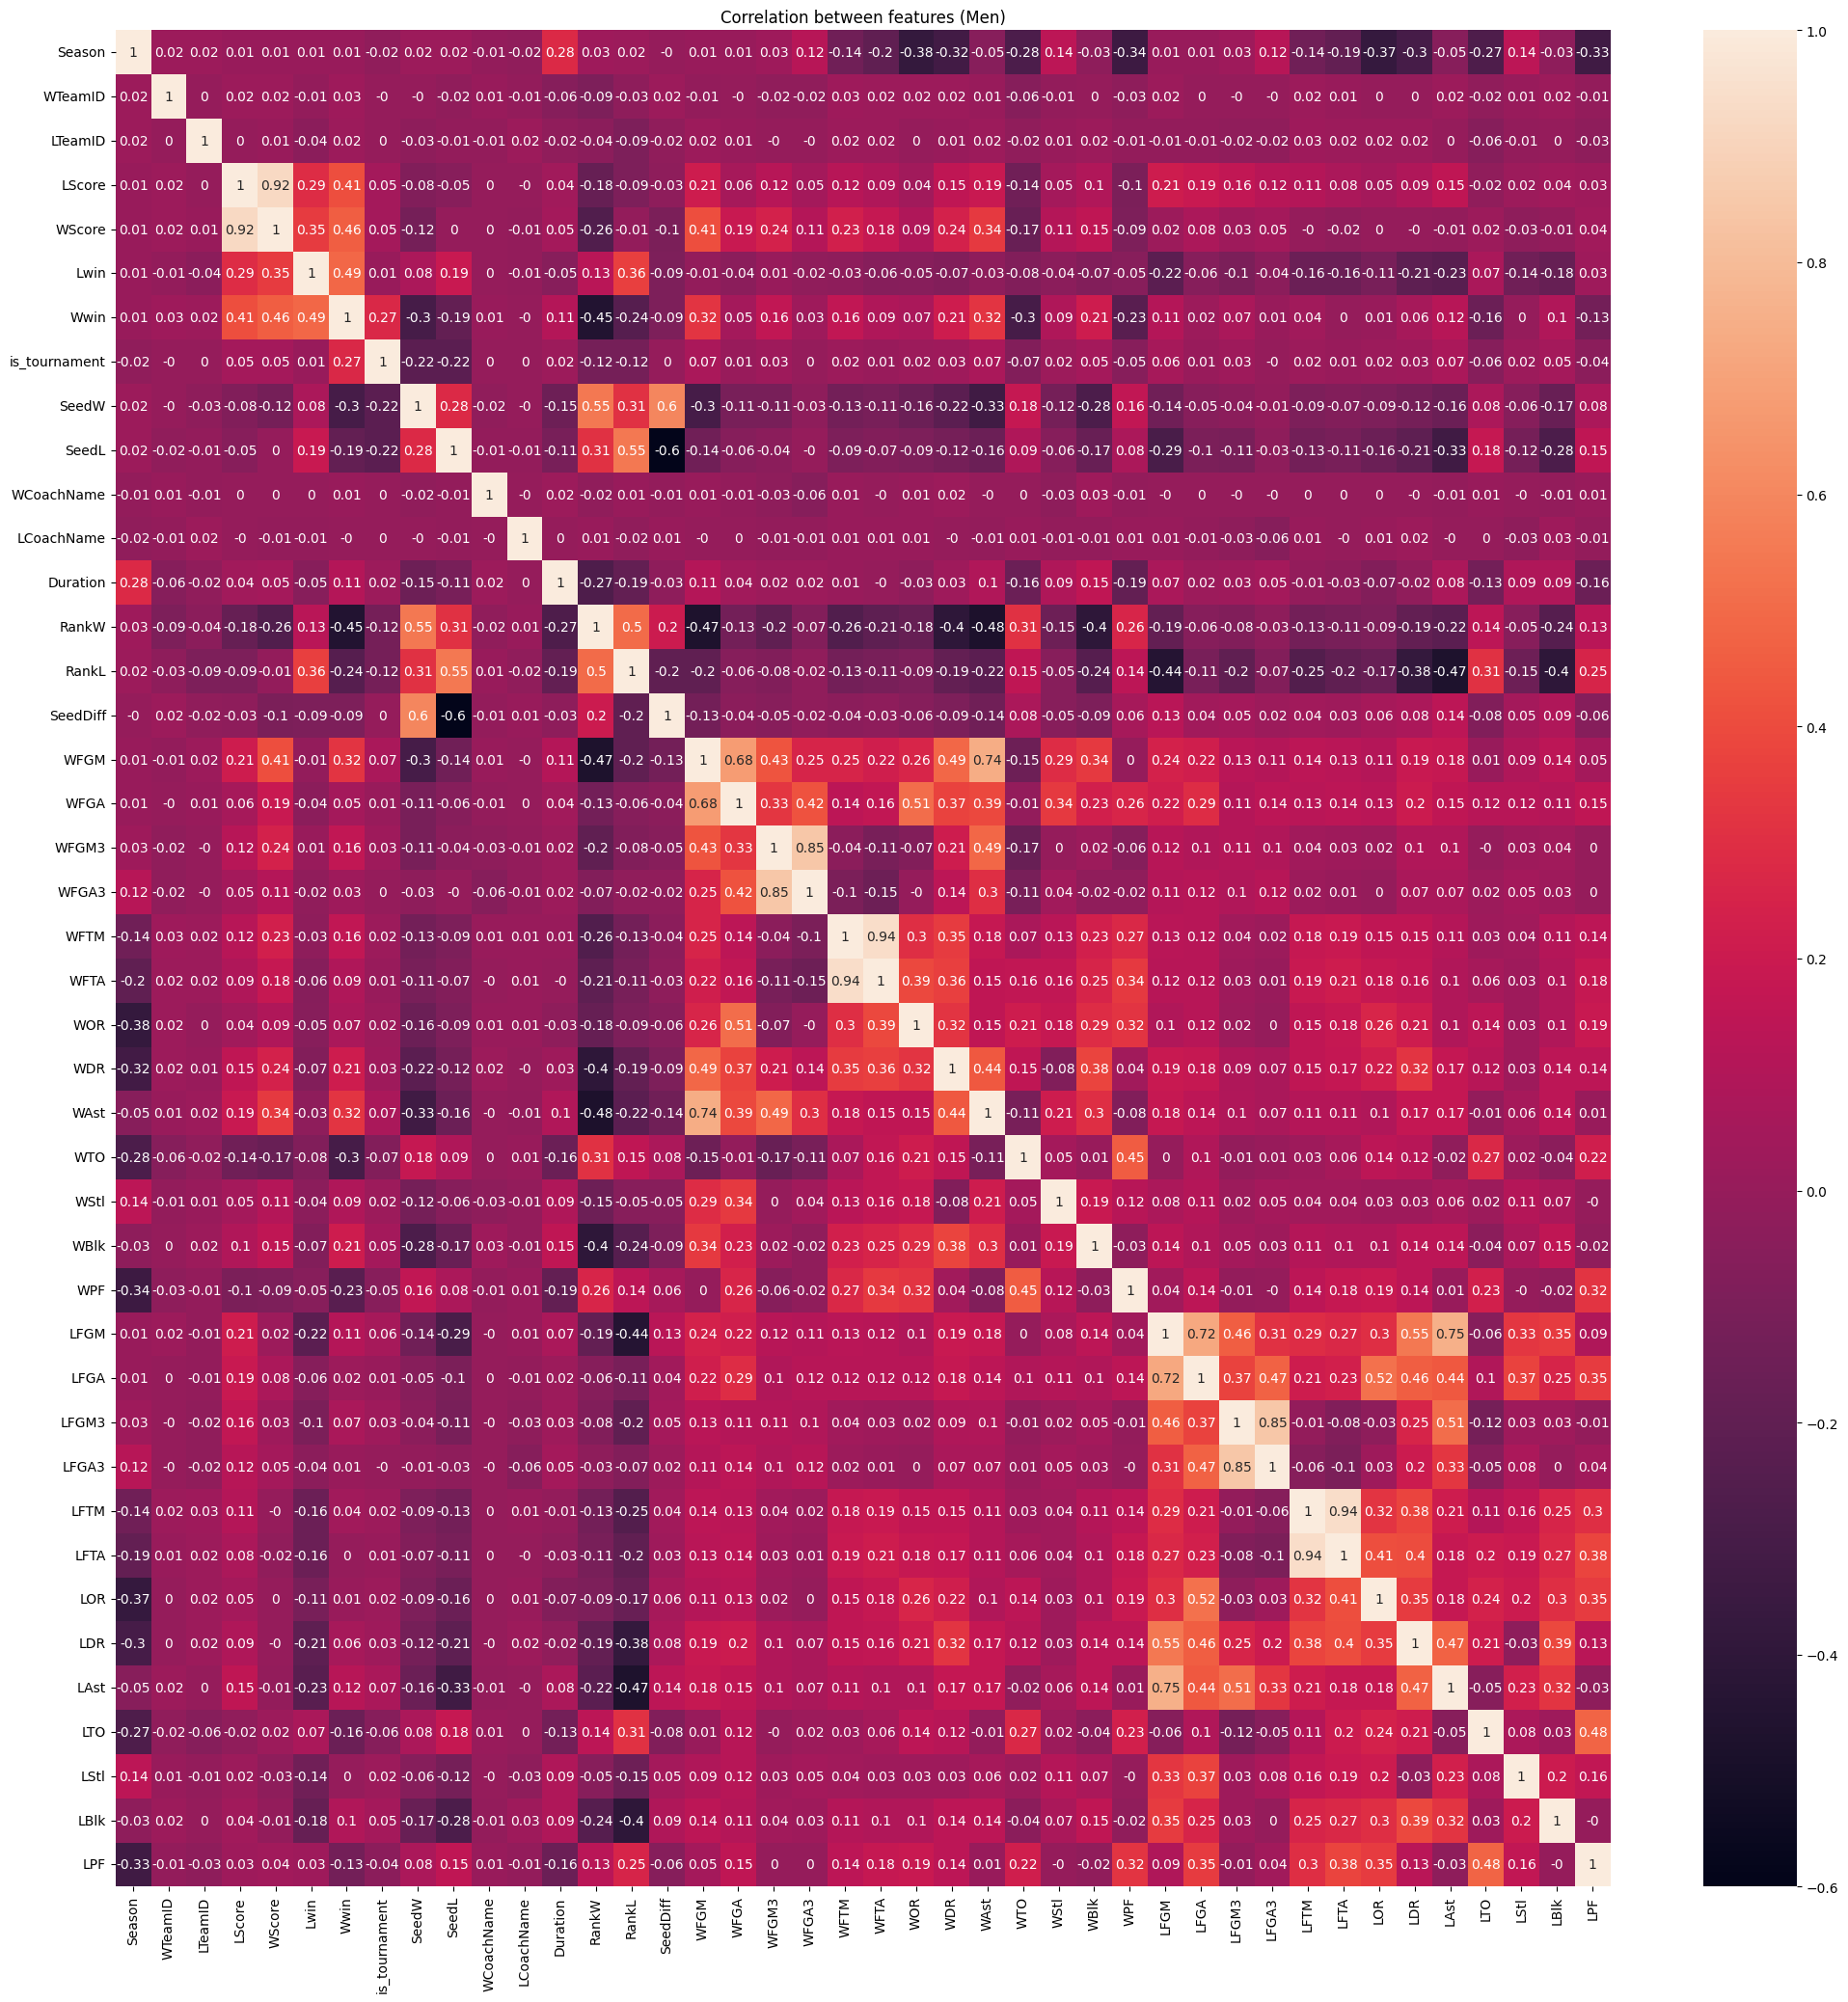

In [17]:
fig, ax = plt.subplots(figsize=(25, 25))
plt.title("Correlation between features (Men)")
sns.heatmap(round(X_trainm.corr(), 2), annot=True, xticklabels=X_trainm.columns, yticklabels=X_trainm.columns)
plt.show()

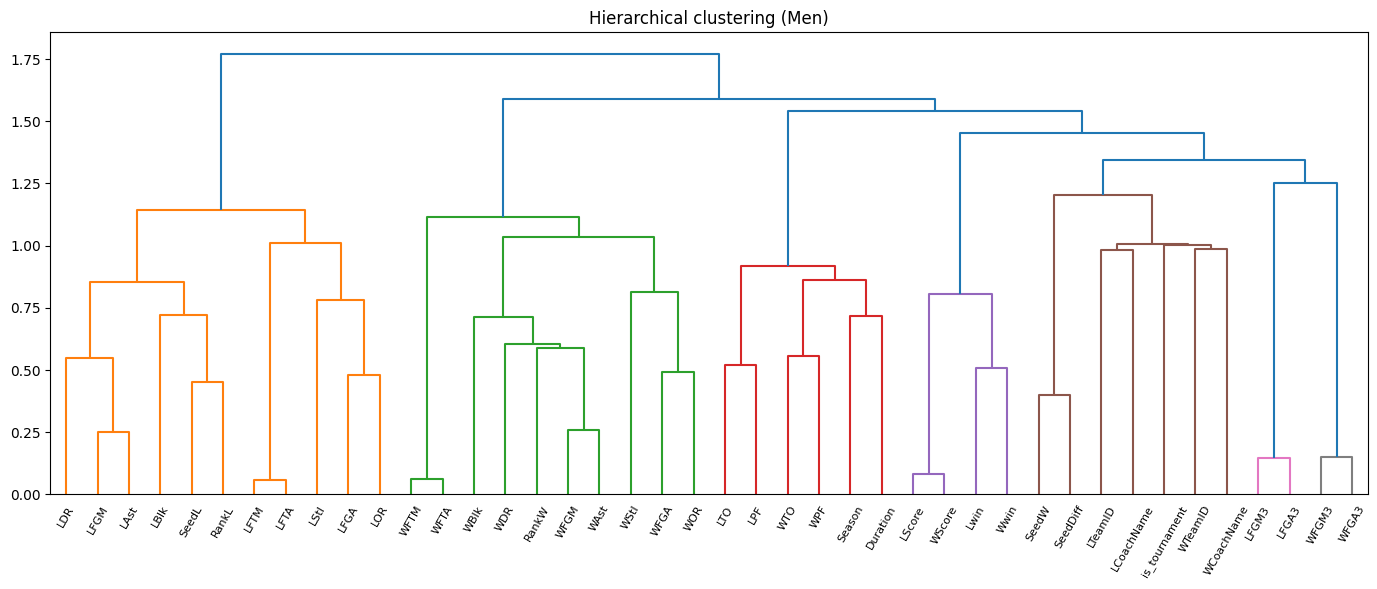

In [18]:
# convert correlation matrix to distance matrix
fig, ax = plt.subplots(figsize=(17, 6))
dist_matrix = 1 - np.abs(X_trainm.corr())
dist_linkage= hierarchy.ward(squareform(dist_matrix))
plt.title("Hierarchical clustering (Men)")
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_trainm.columns.to_list(), ax=ax, leaf_rotation=60
)
plt.show()

In [12]:
dict_of_threshs = {}
list_of_threshs = np.round(np.linspace(0.1, 1.1, 11), 1)
for thresh in list_of_threshs:
    cluster_ids = hierarchy.fcluster(dist_linkage, thresh, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    selected_features_names = X_trainm.columns[selected_features]

    X_train_selected = X_trainm[selected_features_names]
    X_test_selected = X_testm[selected_features_names]

    rf_clfm = RandomForestClassifier(random_state=42)
    rf_clfm.fit(X_train_selected, y_trainm)

    y_predtest = rf_clfm.predict(X_test_selected)
    y_predprobatest = rf_clfm.predict_proba(X_test_selected)

    f1_result = round(f1_score(y_testm, y_predtest), 3)
    brier_score = round(brier_score_loss(y_testm, y_predprobatest), 3)
    dict_of_threshs[thresh] = {"f1_score" : f1_result, "brier_score" : brier_score}
    print(f"Thresh: {thresh}, brier score: {brier_score}, f1 score: {f1_result}")

Thresh: 0.1, brier score: 0.205, f1 score: 0.664
Thresh: 0.2, brier score: 0.205, f1 score: 0.668
Thresh: 0.3, brier score: 0.205, f1 score: 0.667
Thresh: 0.4, brier score: 0.205, f1 score: 0.665
Thresh: 0.5, brier score: 0.211, f1 score: 0.659
Thresh: 0.6, brier score: 0.211, f1 score: 0.655
Thresh: 0.7, brier score: 0.211, f1 score: 0.655
Thresh: 0.8, brier score: 0.213, f1 score: 0.65
Thresh: 0.9, brier score: 0.216, f1 score: 0.648
Thresh: 1.0, brier score: 0.216, f1 score: 0.65
Thresh: 1.1, brier score: 0.219, f1 score: 0.646


#### Women

In [13]:
rf_clfw = RandomForestClassifier()
rf_clfw.fit(X_trainw, y_trainw)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
perm_import = permutation_importance(rf_clfw, X_testw, y_testw, random_state=42)

In [15]:
perm_df = pd.DataFrame({"Col_name" : X_trainw.columns, "Mean importance" : perm_import.importances_mean, "Std importance" : perm_import.importances_std}).sort_values("Mean importance", ascending=False).reset_index(drop=True)
perm_df

,Col_name,Mean importance,Std importance
0,LFGM,0.010719,0.000940
1,SeedDiff,0.008540,0.000555
2,WScore,0.008034,0.003062
3,LTO,0.007606,0.001422
4,WTO,0.007100,0.000814
5,SeedW,0.003891,0.001767
6,WFGM,0.003813,0.003522
7,LAst,0.003249,0.000852
8,WAst,0.003210,0.001550
9,Wwin,0.003171,0.001864


In [16]:
y_predtrain = rf_clfw.predict(X_trainw)
y_predtest = rf_clfw.predict(X_testw)
print(f"Training f1-score {round(f1_score(y_trainw, y_predtrain), 3)}")
print(f"Test f1-score {round(f1_score(y_testw, y_predtest), 3)}")

Training f1-score 1.0
Test f1-score 0.706


As before in the Men's dataset I will examine how are features correlated to further reduced them with permutation based feature selection.

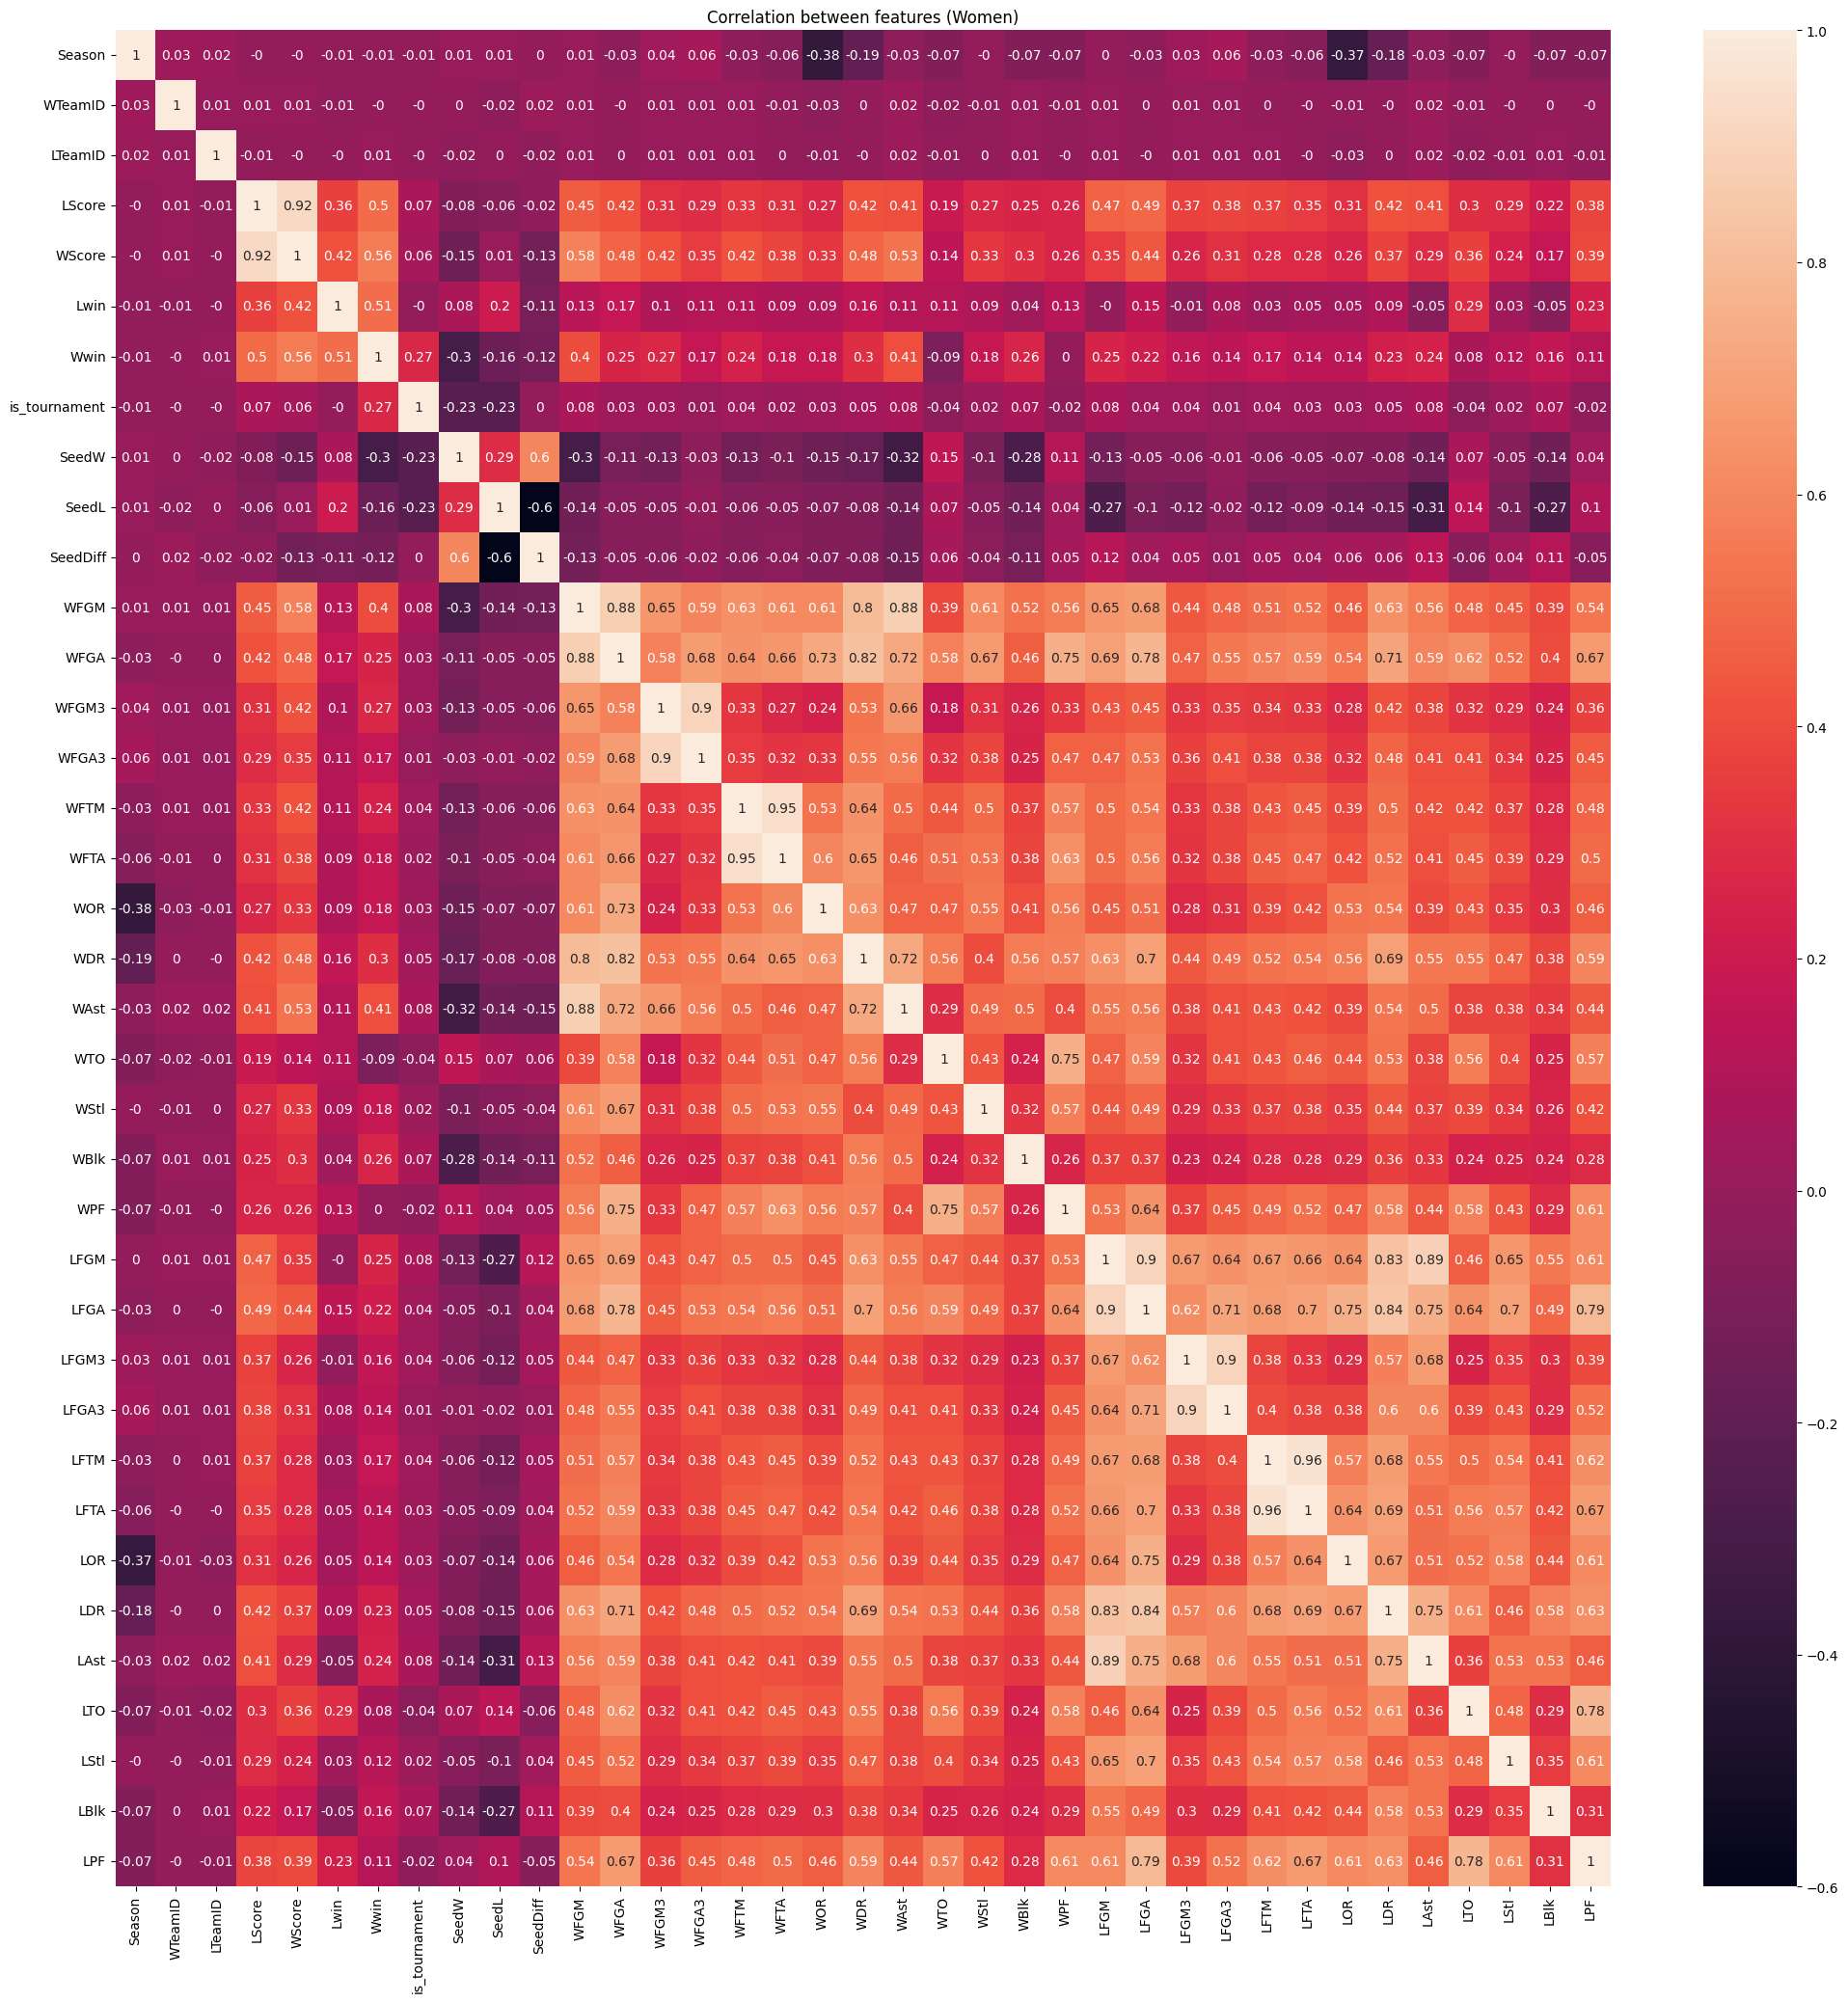

In [19]:
fig, ax = plt.subplots(figsize=(25, 25))
plt.title("Correlation between features (Women)")
sns.heatmap(round(X_trainw.corr(), 2), annot=True, xticklabels=X_trainw.columns, yticklabels=X_trainw.columns)
plt.show()

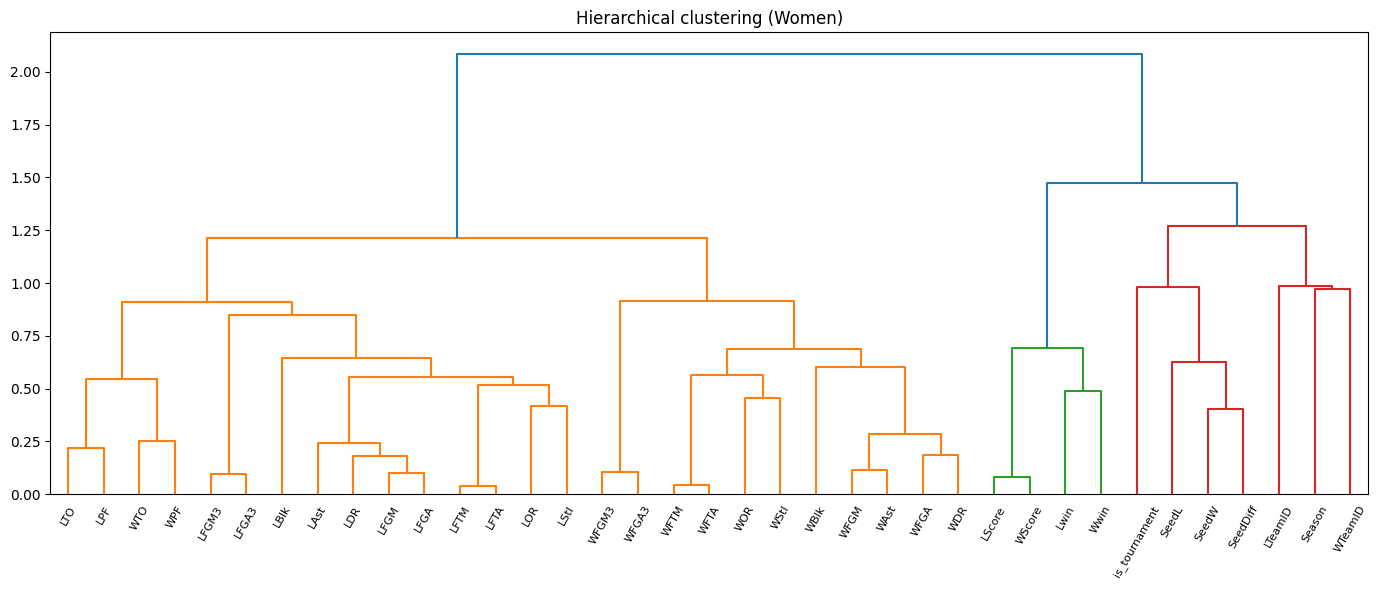

In [22]:
# convert correlation matrix to distance matrix
fig, ax = plt.subplots(figsize=(17, 6))
dist_matrix = 1 - np.abs(X_trainw.corr())
dist_linkage= hierarchy.ward(squareform(dist_matrix))
plt.title("Hierarchical clustering (Women)")
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_trainw.columns.to_list(), ax=ax, leaf_rotation=60
)
plt.show()

In [23]:
dict_of_threshs = {}
list_of_threshs = np.round(np.linspace(0.1, 1.1, 11), 1)
for thresh in list_of_threshs:
    cluster_ids = hierarchy.fcluster(dist_linkage, thresh, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    selected_features_names = X_trainw.columns[selected_features]

    X_train_selected = X_trainw[selected_features_names]
    X_test_selected = X_testw[selected_features_names]

    rf_clfw = RandomForestClassifier(random_state=42)
    rf_clfw.fit(X_train_selected, y_trainw)

    y_predtest = rf_clfw.predict(X_test_selected)
    y_predprobatest = rf_clfw.predict_proba(X_test_selected)

    f1_result = round(f1_score(y_testw, y_predtest), 3)
    brier_score = round(brier_score_loss(y_testw, y_predprobatest), 3)
    dict_of_threshs[thresh] = {"f1_score" : f1_result, "brier_score" : brier_score}
    print(f"Thresh: {thresh}, brier score: {brier_score}, f1 score: {f1_result}")

Thresh: 0.1, brier score: 0.189, f1 score: 0.709
Thresh: 0.2, brier score: 0.189, f1 score: 0.706
Thresh: 0.3, brier score: 0.19, f1 score: 0.701
Thresh: 0.4, brier score: 0.19, f1 score: 0.701
Thresh: 0.5, brier score: 0.192, f1 score: 0.705
Thresh: 0.6, brier score: 0.195, f1 score: 0.697
Thresh: 0.7, brier score: 0.203, f1 score: 0.68
Thresh: 0.8, brier score: 0.203, f1 score: 0.68
Thresh: 0.9, brier score: 0.205, f1 score: 0.676
Thresh: 1.0, brier score: 0.225, f1 score: 0.644
Thresh: 1.1, brier score: 0.225, f1 score: 0.644


### PCA

### Autoencoder